In [28]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
seqeuence_length = 4
batch_size = 1
input_dim = 512 # just the input vector dim
d_model = 512 # Output dim or the model for single word
x = torch.randn((batch_size, seqeuence_length, input_dim))
x.shape

torch.Size([1, 4, 512])

In [7]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

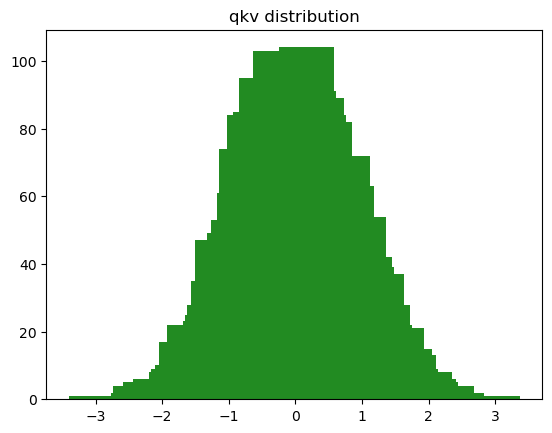

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align="center", color=["forestgreen"])
plt.title("qkv distribution")

In [25]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, seqeuence_length, num_heads, 3 * head_dim)
print(qkv.shape)
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 4, 8, 192])


torch.Size([1, 8, 4, 192])

In [26]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self-Attention for multiple heads

In [29]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [30]:
k.transpose(-2, -1).shape, k.shape

(torch.Size([1, 8, 64, 4]), torch.Size([1, 8, 4, 64]))

In [36]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][0]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [37]:
(scaled + mask)[0][0]

tensor([[-0.0096,    -inf,    -inf,    -inf],
        [-0.2255, -0.0421,    -inf,    -inf],
        [-0.1652, -0.1686,  0.1667,    -inf],
        [-0.0621,  0.2348,  0.0273,  0.6366]], grad_fn=<SelectBackward0>)

In [41]:
scaled += mask
attention = F.softmax(scaled, dim=-1)
attention.shape, attention[0][0]

(torch.Size([1, 8, 4, 4]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4543, 0.5457, 0.0000, 0.0000],
         [0.2950, 0.2940, 0.4111, 0.0000],
         [0.1835, 0.2469, 0.2006, 0.3690]], grad_fn=<SelectBackward0>))

In [42]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Putting all together

In [44]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

values, attention = scaled_dot_product(q, k, v, mask=None)

In [46]:
values.shape, attention.shape

(torch.Size([1, 8, 4, 64]), torch.Size([1, 8, 4, 4]))

In [54]:
values = values.permute(0, 2, 1, 3).reshape(batch_size, seqeuence_length, num_heads * head_dim)
values.shape

torch.Size([1, 4, 512])

In [55]:
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])